In [12]:
# import necessary libaries and data files
import numpy as np
from data import datas
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


#load data and manupulate datas if needed
bus_data, line_data, load_data, gen_data, wind_data = datas() #data loading

line_data = pd.DataFrame(line_data).sort_values(by=[0,1]).values #line data sorting and data type change

bus_data = pd.DataFrame(bus_data).sort_values(by = [0]).values #Bus data sorting and data type change

R = line_data[:, 2]
X = line_data[:, 3]
B = 0.5j * line_data[:, 4]
taps = line_data[:,5]
Bsh = 1j* bus_data[:, 3]
Z = R + 1j * X
Y = 1 / Z
nline = len(line_data[:, 0])
nbus = int(np.amax(line_data[:, :2]))  # Total Number of buses
b_fr = line_data[:,0]
b_to = line_data[:,1]


In [13]:
def tap_handle(x):
    '''Function to handle transformer tap ratio'''
    if np.real(x) == 0:
        return 1
    else:
        return 1
    

# Y Bus Formation
def Y_bus():
    '''Function to create Y Bus matrix '''
    Ybus = np.zeros((nbus, nbus), dtype=complex)
    Y1 = np.zeros((73, 73), dtype=complex)
    np.fill_diagonal(Y1,Bsh)
    
    for k in range(nline):
        # Off Diagonal Elements
        Ybus[int(line_data[k, 0]) - 1, int(line_data[k, 1]) - 1] -= (Y[k])/np.conj(tap_handle(taps[k]))
        Ybus[int(line_data[k, 1]) - 1, int(line_data[k, 0]) - 1] -= (Y[k])/tap_handle(taps[k])

        # Diagonal Elements
        Ybus[int(line_data[k, 0]) - 1, int(line_data[k, 0]) - 1] += (Y[k] + B[k])/pow(abs(tap_handle(taps[k])),2)
        Ybus[int(line_data[k, 1]) - 1, int(line_data[k, 1]) - 1] += Y[k] + B[k]
    
    Y_bus_ = Ybus + Y1
    return Y_bus_

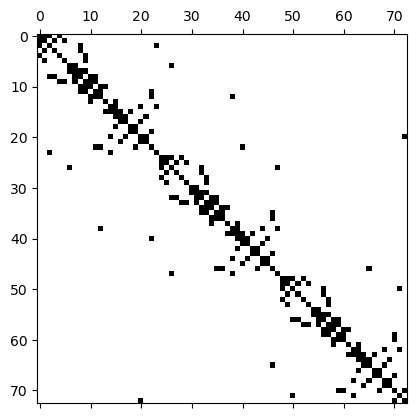

In [14]:

plt.spy(Y_bus())

In [15]:

line_data_ = pd.DataFrame(line_data).astype({0:int, 1:int, 2:float, 3:float, 4:float, 
                                            6:float }).sort_values(by=[0,1]) #line data sorting and data type change
def incidence_matrix():
    incidence_matrix = np.zeros((nline, nbus), dtype=int)

    for k in range(nline):
        incidence_matrix[k, int(b_fr[k]) - 1] = 1  # Leaving  from bus
        incidence_matrix[k, int(b_to[k]) - 1] = -1     # arriving to bus

    return incidence_matrix

def diag_Y_L():
    Y_l = np.zeros((nline,nline), dtype=complex)
    np.fill_diagonal(Y_l, Y)
    return Y_l

def diag_Y_s():
    Y_s = np.zeros((nbus,nbus), dtype=complex)
    bij = (line_data_.groupby(by = [0]).sum().loc[:,4])/2

    b = np.zeros(nbus)
    for k in bij.index.astype(int):
        if k > 0:
            b[k-1] = bij[k]

    d_s = 1j*b + 1j*Bsh

    np.fill_diagonal(Y_s, d_s)
    return Y_s


E = incidence_matrix()
Yl = diag_Y_L()
Ys = diag_Y_s()

Y_E_bus = np.dot(np.dot((E.T), Yl), E) + Ys

Y_Bus = Y_bus()

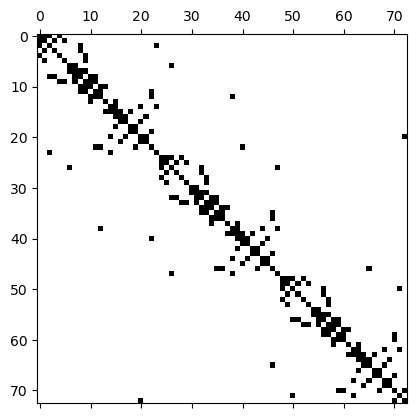

In [16]:
plt.spy(Y_E_bus)

In [17]:
np.linalg.norm((Y_E_bus - Y_Bus))

0.8548382888008846